Install dependencies

In [1]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


Read data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_folder = '../../datasets/rating-based-dataset/'

scores_data = pd.read_csv(data_folder + "data/ae_only_unambiguous_1000.csv", low_memory=False)

_images = scores_data['website'].unique()
_scores = scores_data.groupby('website')['mean_response'].apply(list)

del scores_data

Get images path.

In [3]:
all_images = []
scores = []
images_path = data_folder + 'preprocess/resized'

for image in _images:

  # english websites
  if 'english' in image:
    all_images.append(images_path + '/english_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

  # foreign websites
  if 'foreign' in image:
    all_images.append(images_path + '/foreign_resized/' + image[8:] + '.png')  
    scores.append(_scores[image])

print('Total number of images: %d' % len(all_images))

Total number of images: 398


Get the path of the images in test set and the ground truth user aesthetics ratings for each website. 

In [4]:
import csv

test_data_path = data_folder + 'preprocess/test_list.csv'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)

    return (images, scores)

test_images_names, gt_scores = get_scores(test_data_path)

Form training and test data 
* {train, test}_images: contains the path of each image
* {train, test}_scores: contains the user ratings of each image

In [5]:
train_images =[]
train_scores =[]

test_images = test_images_names
test_scores = [[]] * len(test_images)

for i in range(0, len(all_images)):
  if all_images[i] in test_images_names:

    pos = test_images_names.index(all_images[i])

    test_scores[pos] = scores[i]
  else:
    train_images.append(all_images[i])
    train_scores.append(scores[i])

In [6]:
all_images_combined = train_images + test_images
all_scores_combined = train_scores + test_scores

data = {'image': all_images_combined, 'score': all_scores_combined}
df = pd.DataFrame(data)
mean_score = []

for i in df.score: #obtenemos el promedio de los scores
    mean = 0
    for j in i:
        mean += j
    
    mean = mean / len(i)
    mean_score.append(round(mean, 0))

df.insert(1, 'mean_score', mean_score)


value_counts = df['mean_score'].value_counts() #eliminamos los estratos con menos de dos muestras
to_keep = value_counts[value_counts >= 2].index
df = df[df['mean_score'].isin(to_keep)]

In [7]:

from sklearn.model_selection import train_test_split

# Stratify split
train_df, test_df = train_test_split(df,
                                     test_size=0.243, 
                                     stratify=df['mean_score'], 
                                     random_state=42)

train_images = train_df['image'].tolist()
train_scores = train_df['score'].tolist()

test_images = test_df['image'].tolist()
test_scores = test_df['score'].tolist()

print("Distribución en el conjunto de entrenamiento:")
print(train_df['score'].value_counts(normalize=True))
print("\nDistribución en el conjunto de prueba:")
print(test_df['score'].value_counts(normalize=True))

Distribución en el conjunto de entrenamiento:
score
[4.5, 2.0, 5.0, 6.0, 5.0, 4.5, 8.0, 2.5, 6.5, 5.5, 6.0, 4.0, 5.0, 3.5, 3.0, 5.0, 6.0, 2.5, 5.0, 3.0, 4.0, 7.5, 2.5, 6.5, 5.5, 6.0, 3.0, 4.5, 7.5, 6.0, 3.5, 3.5, 5.0, 3.5, 5.5, 3.5, 5.5, 8.5, 5.5, 3.5, 6.0, 2.5, 4.0, 5.0, 6.5, 7.0, 4.0, 6.0, 4.5, 1.5, 4.0, 3.5, 2.0, 3.0, 3.5, 5.0, 3.0, 5.5, 4.5, 7.0, 4.5, 4.0, 4.0, 4.0, 6.0, 3.0, 7.0, 7.0, 3.5, 5.0, 6.5, 7.5, 7.0, 8.5, 3.0, 1.0, 5.5, 4.0, 7.5, 5.5, 3.5, 3.0, 4.5, 3.0, 5.0, 4.5, 8.0, 7.0, 3.5, 3.0, 6.0, 5.0, 3.5, 5.5, 5.0, 2.5, 5.0, 6.0, 1.5, 2.5, ...]    0.003333
[6.5, 3.0, 8.0, 5.5, 1.5, 4.0, 5.5, 3.0, 1.5, 2.5, 3.0, 1.0, 4.0, 5.0, 4.0, 5.0, 3.5, 2.0, 2.0, 2.5, 3.0, 1.5, 3.0, 2.0, 7.0, 3.0, 4.0, 6.5, 2.5, 5.5, 5.5, 1.5, 6.5, 1.0, 6.0, 6.0, 4.0, 1.5, 3.5, 3.0, 7.0, 6.5, 4.0, 3.5, 5.0, 2.5, 2.0, 6.0, 4.5, 4.0, 2.5, 5.5, 3.5, 3.0, 7.5, 5.0, 1.0, 4.0, 1.0, 4.5, 4.0, 3.5, 1.5, 2.5, 3.5, 3.5, 5.5, 3.0, 2.5, 3.5, 4.5, 3.0, 7.0, 6.0, 4.0, 3.0, 7.5, 1.5, 5.5, 4.5, 5.5, 4.0, 4.5, 3.0, 2.0, 2.5,

Shuffle the training set

In [8]:
import random

# np.random.seed(2000)
    
temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)

Display the first 3 images to make sure everything is ok. 

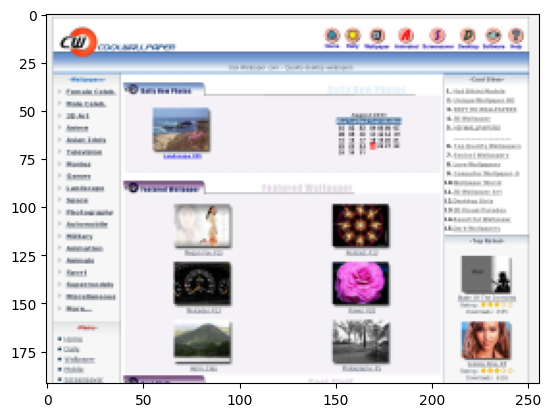

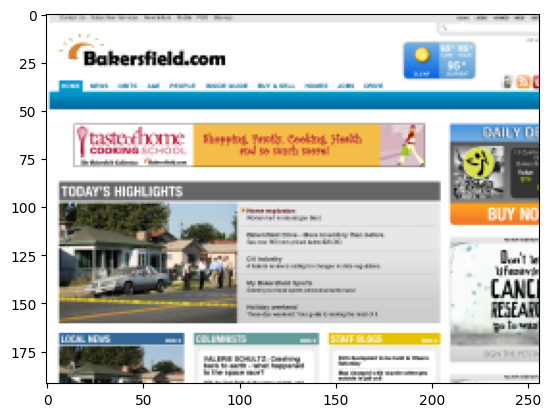

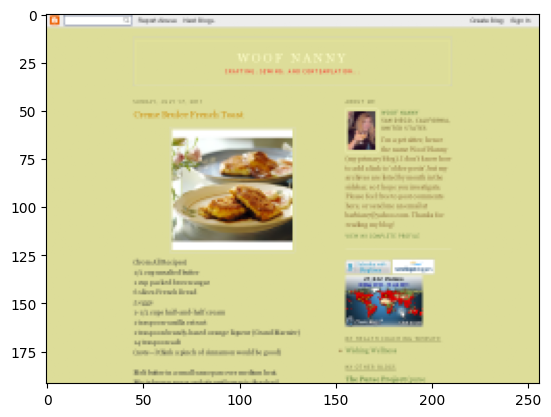

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
  img = mping.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

Read the images as numpy arrays

In [10]:
import cv2

width = 256 
height = 192 
channels = 3

def read_and_process_images(list_of_images):
  X = []
  
  for image in list_of_images:

    # images are already resized
    # X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height), 
    #                     interpolation=cv2.INTER_AREA))
    X.append(cv2.imread(image, cv2.IMREAD_COLOR))

  
  return X


X_train = np.array(read_and_process_images(train_images))
X_val = np.array(read_and_process_images(test_images))

Display the first 3 images to make sure everything is ok

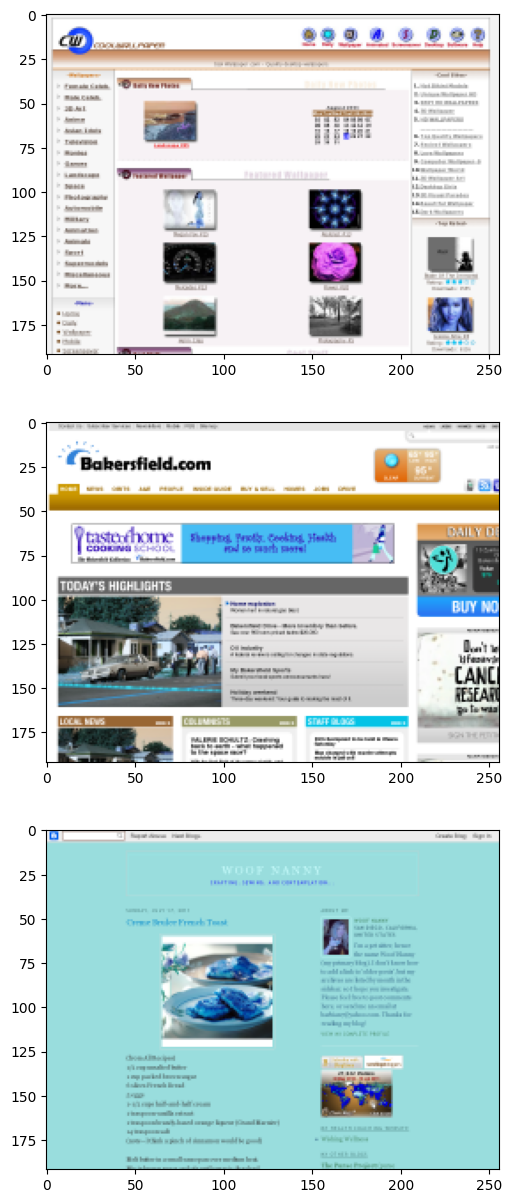

In [11]:
plt.figure(figsize=(25,15))
columns = 3

for i in range(columns):
  plt.subplot(columns, 1, i+1)
  plt.imshow(X_train[i])

The ground truth distribution of human ratings of a given website can be expressed as an empirical probability mass function **p** = [p<sub>s<sub>1</sub></sub>, p<sub>s<sub>2</sub></sub>, ..., p<sub>s<sub>N</sub></sub>] with s<sub>1</sub> &#8804; s<sub>i</sub> &#8804; s<sub>N</sub>, where s<sub>i</sub> denotes the i-th score bucket and N denotes the total number of buckets. In this case, s<sub>1</sub>=1 and s<sub>N</sub>=9.


In [12]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
score_values = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

y_train = []

for i in range(0, len(train_scores)):
  y_temp = np.histogram(train_scores[i], bins=bins)[0]
  y_train.append(y_temp / len(train_scores[i]))
  del y_temp

y_train = np.array(y_train)

y_val = []

for i in range(0, len(test_scores)):
  y_temp = np.histogram(test_scores[i], bins=bins)[0]
  y_val.append(y_temp / len(test_scores[i]))
  del y_temp

y_val = np.array(y_val)


Display shapes to check everything is ok

In [13]:
ntrain = len(X_train)
nval = len(X_val)

print('Shape of X_train is: ', X_train.shape)
print('Shape of X_val is: ', X_val.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of y_val is: ', y_val.shape)
print('Number of training samples: ', ntrain)
print('Number of validation samples: ', nval)

Shape of X_train is:  (300, 192, 256, 3)
Shape of X_val is:  (97, 192, 256, 3)
Shape of y_train is:  (300, 9)
Shape of y_val is:  (97, 9)
Number of training samples:  300
Number of validation samples:  97


Construct the CNN. The task is to predict the user aesthetics score distribution for a website. We will use [NIMA-MobileNet](https://arxiv.org/pdf/1709.05424.pdf) as our base network. This network is pretrained on AVA dataset (containing 255k image with aesthetic quality ratings) for the neural image assessment task.

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

input_shape = X_train[0].shape

base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=input_shape)

x = base_model.output
x = Dropout(0.6)(x) 
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.load_weights('../../pretrained-models/mobilenet_weights.h5')

model.layers.pop()
outputs = Dense(9, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.input, outputs=outputs)

model.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../pretrained-models/mobilenet_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Define the loss function (Earth Mover's Distance)

In [ ]:
from tensorflow.keras import backend as K

def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    casted_cdf_ytrue = K.cast(cdf_ytrue, "float64")
    casted_cdf_ypred = K.cast(cdf_ypred, "float64")
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(casted_cdf_ytrue - casted_cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_earth_mover_loss',  # Metrica a monitorear
    patience=10,                     # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True        # Restaurar los mejores pesos cuando se detenga el entrenamiento
)

Compile the model.

In [ ]:
epochs = 150
decay = 1e-4 
base_lr = 0.005

sgd = optimizers.SGD(learning_rate=base_lr, momentum=0.9, weight_decay=decay, nesterov=True)
model.compile(loss=earth_mover_loss, optimizer=sgd, metrics=[earth_mover_loss, 'accuracy'])

Train the model.

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=nval // batch_size)
                    #callbacks=[early_stopping])

Epoch 1/150


9/9 [==============================] - 17s 1s/step - loss: 0.1588 - earth_mover_loss: 0.1576 - accuracy: 0.0709 - val_loss: 0.1541 - val_earth_mover_loss: 0.1541 - val_accuracy: 0.0625
Epoch 2/150
9/9 [==============================] - 11s 1s/step - loss: 0.1574 - earth_mover_loss: 0.1588 - accuracy: 0.0672 - val_loss: 0.1526 - val_earth_mover_loss: 0.1526 - val_accuracy: 0.0625
Epoch 3/150
9/9 [==============================] - 11s 1s/step - loss: 0.1582 - earth_mover_loss: 0.1596 - accuracy: 0.0634 - val_loss: 0.1510 - val_earth_mover_loss: 0.1510 - val_accuracy: 0.0625
Epoch 4/150
9/9 [==============================] - 10s 1s/step - loss: 0.1563 - earth_mover_loss: 0.1563 - accuracy: 0.0821 - val_loss: 0.1494 - val_earth_mover_loss: 0.1494 - val_accuracy: 0.0625
Epoch 5/150
9/9 [==============================] - 11s 1s/step - loss: 0.1550 - earth_mover_loss: 0.1544 - accuracy: 0.0858 - val_loss: 0.1487 - val_earth_mover_loss: 0.1487 - val_accuracy: 0.0938
Epoch 6/150
9

Display the learning curves.

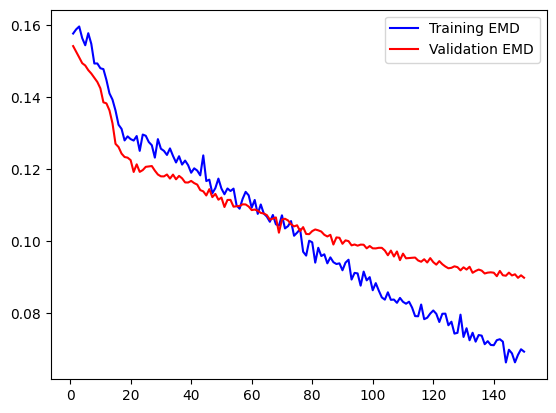

In [ ]:

emd = history.history["earth_mover_loss"]
val_emd = history.history["val_earth_mover_loss"]

epochs_x = range(1, len(emd) + 1)

plt.plot(epochs_x, emd, 'b', label='Training EMD')
plt.plot(epochs_x, val_emd, 'r', label='Validation EMD')

plt.legend()

plot accuracy

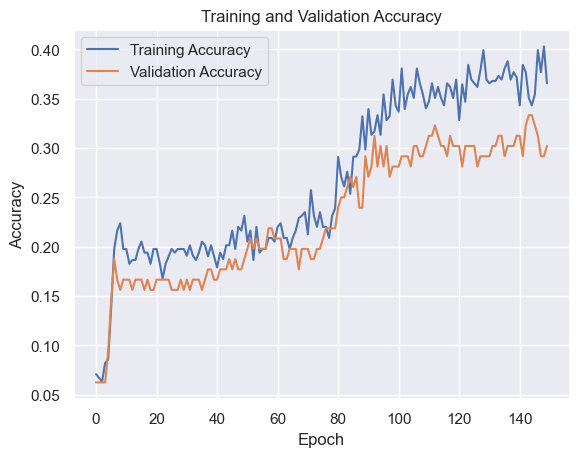

In [ ]:
#import matplotlib.pyplot as plt

# Get the accuracy values from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Define a function that calculates Pearson correlation.

In [ ]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

Predict aesthetics score of the webpages in the test set. The mean value of the predicted distribution is used as the final aesthetics score.

In [ ]:
predictions = []

X_val = X_val / 255.0

for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = model.predict(img)

  predictions.append(float(np.sum(pred[0] * score_values)))

gt_scores = np.array(gt_scores)
predictions = np.array(predictions)

1/1 [==============================] - 0s 40ms/step


Get model accuracy

In [ ]:
accuracy = model.evaluate(X_val, y_val)[1]
accuracy

4/4 [==============================] - 1s 214ms/step - loss: 0.0895 - earth_mover_loss: 0.0819 - accuracy: 0.2959


0.08193746209144592

Display some websites of the test set and the predicted aesthetics score.

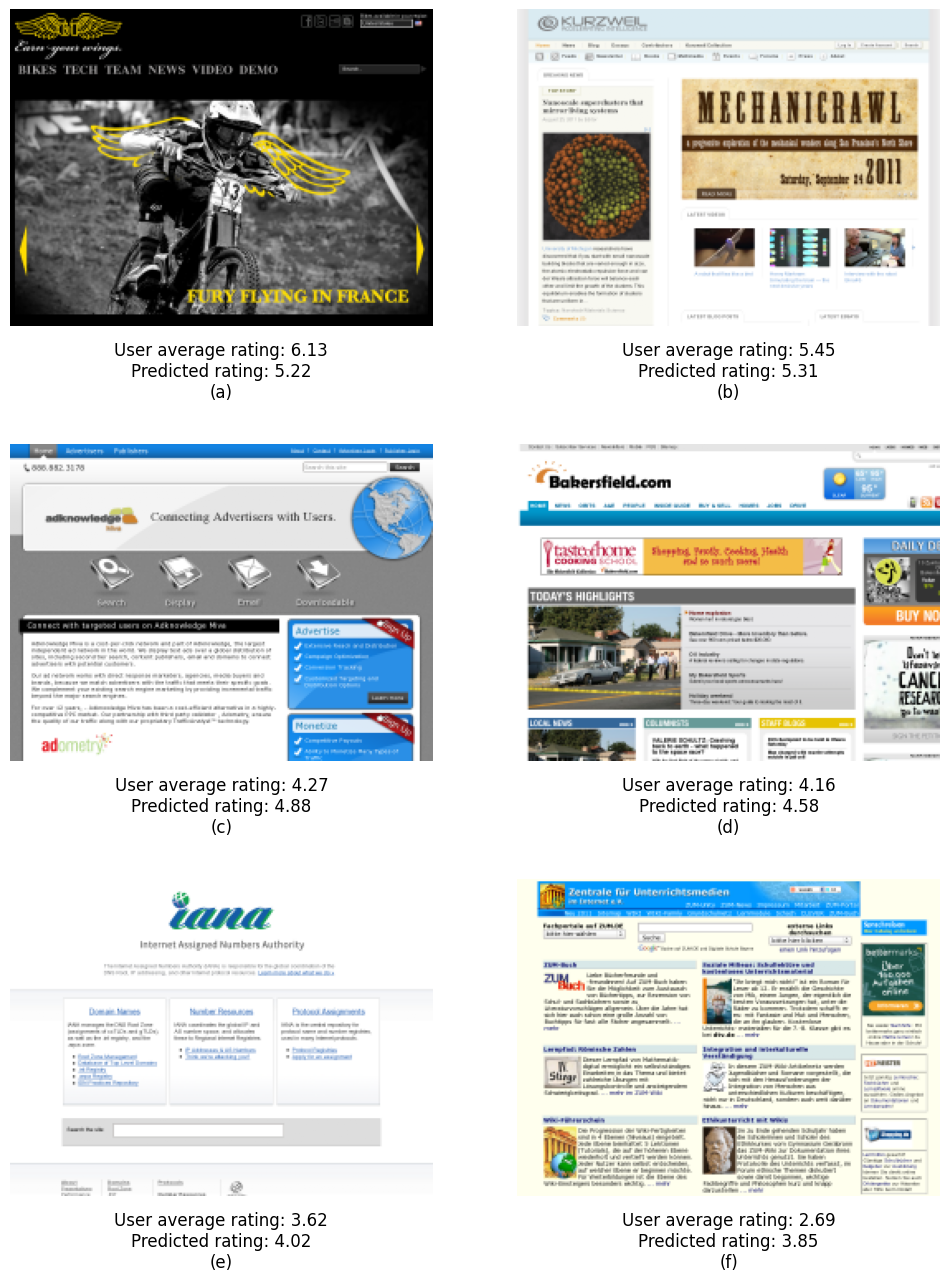

In [ ]:
image_ids = [87, 45, 49, 94, 14, 83] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1]
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]
 
  plt.subplot(int(len(image_ids)/2), 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(gt_scores[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)
    
  i += 1

plt.show()

Create a scatterplot to check the relationship between ground truth and predicted scores.

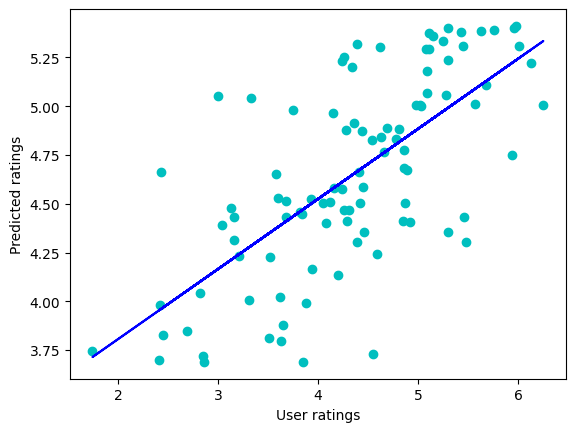

In [ ]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(gt_scores, predictions, 1)

fig = plt.figure()
plt.scatter(gt_scores, predictions, c='c')
plt.plot(gt_scores, b + m * gt_scores, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

Calculate the Pearson correlation and the RMSE between ground truth and predicted scores.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt


corr, p, lo, hi = pearsonr_ci(gt_scores, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(gt_scores, predictions))
print('RMSE: %.3f' % rmse_test)

# accuracy of the model
print('Accuracy: %.2f' % accuracy)

Pearsons correlation: r=0.69, p=3.76e-15, CI=[0.57, 0.78]
RMSE: 0.776
Accuracy: 0.08


Plot the distribution of ground truth scores and the distribution of predictions.

C:\Users\Abraham\AppData\Local\Temp\ipykernel_29944\4222732542.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gt_scores, bins=bins, label='User ratings', kde=True)
C:\Users\Abraham\AppData\Local\Temp\ipykernel_29944\4222732542.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions

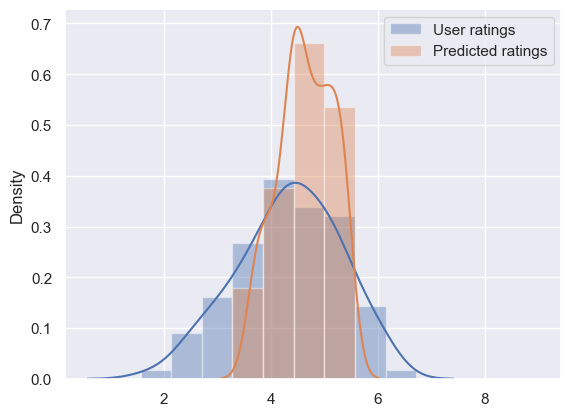

In [ ]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(gt_scores, bins=bins, label='User ratings', kde=True)

sns.distplot(predictions, bins=bins, label='Predicted ratings', kde=True)

plt.legend()


plt.show()

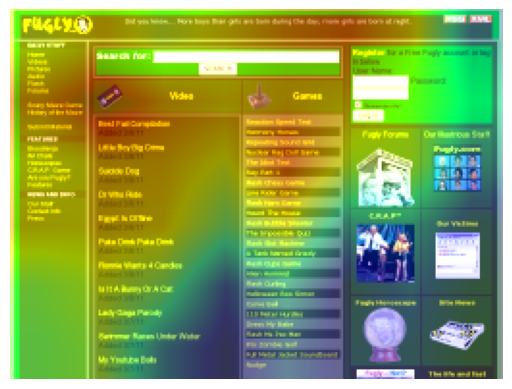

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random

def get_img_array(img_path, size):
    """Preprocess the image to get it ready for prediction"""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    """Generates a Grad-CAM heatmap for a given image and model"""
    # Asegúrate de que model.inputs es una lista de KerasTensors
    inputs = model.inputs if isinstance(model.inputs, list) else [model.inputs]
    
    grad_model = tf.keras.models.Model(
        inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Superimposes the heatmap on the original image and saves it"""
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    cv2.imwrite(cam_path, superimposed_img)
    return superimposed_img

# Ensure that the layer names match your model
last_conv_layer_name = 'conv_pw_13'
classifier_layer_names = ['global_average_pooling2d', 'dropout', 'dense', 'dense_1']

random_image_number = random.randint(0, len(all_images) - 1)

# Generate the Grad-CAM heatmap
img_array = get_img_array(all_images[17], (192, 256))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Superimpose the heatmap on the original image
superimposed_img = save_and_display_gradcam(all_images[17], heatmap)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


In [ ]:
model.save('mi_modelo.h5')

c:\Users\Abraham\Proyectos\website-aesthetics-research\.conda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.

SyntaxError: invalid syntax (1068564517.py, line 1)